In [1]:
#import library
import numpy as np
import pandas as pd
from datetime import date
from neupy import algorithms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import keras
from keras import regularizers
import pyrenn as prn
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [37]:
file_parameters = ['ch', 'cv', 'ExG', 'NDVI']
plant_date = '0401'
limit_day = 105
interval_day = 7
x_pred = range(interval_day, limit_day+1, interval_day)
path = 'sigmoid_2016_spring/sigmoid_2016_spring{}.csv'
# sigmoi_2016_spring_ch.csv
yield_path = '2016_spring/2016_spring.csv'

In [38]:
parameter = 'ch'
term = pd.read_csv(path.format('_'+parameter))
term.head

<bound method NDFrame.head of      max_value  max_growth_rate  half_max_growth_rate  first_day_half_max  \
0     1.132855         0.027922              0.014146                42.0   
1     1.272441         0.028461              0.014705                35.0   
2     1.378696         0.030998              0.015933                37.0   
3     1.405654         0.032263              0.016535                38.0   
4     1.237971         0.030544              0.015534                39.0   
..         ...              ...                   ...                 ...   
797   0.938958         0.025537              0.012925                38.0   
798   1.008285         0.025323              0.012884                38.0   
799   1.020679         0.024877              0.012716                37.0   
800   1.116538         0.031972              0.016126                39.0   
801   0.822383         0.022021              0.011086                44.0   

     second_day_half_max  duration_half_max  

In [7]:
canopy_dataframe = pd.read_excel('cotton_2016_alldata_row.xlsx', 'ALL')
akash_data = pd.read_excel('CH.xlsx', 'Sheet1')
index_mask = pd.read_excel('index_of_considered_samples.xlsx', 'Sheet1', header = None)

In [8]:
mask  = np.isin(canopy_dataframe['order'].values, index_mask.values) & (canopy_dataframe['Weight per row (lbs)'].values > 0)
# print(canopy_dataframe['order'].values.shape)
# print(index_mask.values.shape)
canopy_dataframe = canopy_dataframe[mask]
print(canopy_dataframe.shape)
print(sum(mask))
# print(canopy_dataframe.shape)
# # print(sum(mask_CH))
canopy_dataframe = canopy_dataframe.reset_index()

(802, 160)
802


In [9]:
original_data = canopy_dataframe.copy()

In [ ]:
def cottonYieldData(parameters):
    x_normalization_mask = []
    processed_data = {}
    std = parameters['std']
    normalization = parameters['normalization']
    interval_day = parameters['interval_day']
    limit_day = parameters['limit_day']
    
    
    
    plant_date = '0401'
    file_parameters = parameters['file_parameters']
    
    for (i, parameter) in enumerate(file_parameters):
    #     print(type(data[parameter]))
        parameter_data = pd.read_csv(path.format('_'+parameter))
        print(parameter_data.shape)
        parameter_data = parameter_data.values
        if i == 0:
             interval_process_data = np.empty([len(parameter_data), 0])
        if normalization:
            x_normalization_mask.append(np.linalg.norm(parameter_data[:,:3]))
            x_normalization_mask.append(np.linalg.norm(parameter_data[:,3:]))
            parameter_data[:,:3] /= np.linalg.norm(parameter_data[:,:3])
            parameter_data[:,3:] /= np.linalg.norm(parameter_data[:,3:])
            
        interval_process_data = np.append(interval_process_data, parameter_data, axis = 1)
#     print(interval_process_data.shape)
    extra_parameters = data_parameters['extra_parameters']
    for parameter in extra_parameters:
        data = original_data[[x for x in original_data.columns if parameter in x]].copy().values.astype(float)
        x_normalization_mask.append(np.linalg.norm(data))
        data /= np.linalg.norm(data)
        interval_process_data = np.append(interval_process_data, data, axis = 1)
        
#     print(interval_process_data.shape)
    one_hot_encoded_parameters = data_parameters['one_hot_encoded_parameters']
     #Added one hot of irrigation
    for parameter in one_hot_encoded_parameters:
        irrigation = pd.DataFrame(original_data[parameter].copy())
        irrigation_values = np.unique(irrigation)
        irrigation[parameter] = irrigation[parameter].map(lambda x: {value:i for (i, value) in enumerate(irrigation_values)}.get(x))
        irrigation = pd.get_dummies(irrigation[parameter])
        interval_process_data = np.append(interval_process_data, irrigation.values, axis = 1)    
        
#     print(interval_process_data.shape)
#      #Added one hot of plantDate
#     test_plant_date = pd.DataFrame(yield_data['plantDate'])
#     test_plant_data_values = np.unique(yield_data['plantDate'].values)
#     test_plant_date['plantDate'] = test_plant_date['plantDate'].map(lambda x: {date:i for (i, date) in enumerate(test_plant_data_values)}.get(x))
#     test_plant_date = pd.get_dummies(test_plant_date['plantDate'])
#     interval_process_data = np.append(interval_process_data, test_plant_date.values, axis = 1)
    
        
    
    
    x_train = interval_process_data 
    y_train = original_data['Weight per row (lbs)'].copy().values
#     print(y_train.shape)
#     print(x_train.shape)
    

    y_normalization_mask = np.linalg.norm(y_train)
    if normalization:
        y_train /= y_normalization_mask

    return(x_train, y_train, x_normalization_mask, y_normalization_mask)


In [ ]:
def process(model_parameters, data_parameters, data_func):
    
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    return(trainModel(x_data, y_data, x_data.shape[1], model_parameters))

In [ ]:
def akashModel(x_data, y_data, input_shape, model_parameter):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
#     x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    x_train = x_train.T
    y_train = y_train.T
    x_test = x_test.T
    y_test = y_test.T
    layer_shape = model_parameters['layer']
    kmax = model_parameters['k_max']
    damp_const = model_parameters['dampconst']
    damp_fac = model_parameters['dampfac']
    E_stop = model_parameters['E_stop']
    verbose = model_parameters['verbose']

    net = prn.CreateNN(np.append(np.append(input_shape, layer_shape), 1))
    net = prn.train_LM(x_train, y_train, net, verbose=verbose,
    dampfac = damp_fac, dampconst = damp_const,
    k_max=kmax, E_stop= E_stop)
    
    y = prn.NNOut(x_train, net)
    y_pred = prn.NNOut(x_test, net)
    acc_sc_chk = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': y.flatten()})
    acc_sc_chk.head()
    r2_score_1 = r2_score(acc_sc_chk.y_train, acc_sc_chk.y_train_pred)
    print('r2 score = ', r2_score_1, '/ 1.0')

    acc_sc_chk_2 = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': y_pred.flatten()})
    acc_sc_chk_2.head()
    r2_score_2 = r2_score(acc_sc_chk_2.y_test, acc_sc_chk_2.y_test_pred)
    print('r2 score = ', r2_score_2, '/ 1.0')
    
    fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 6))
    ax[0].scatter(range(len(y_train)), y_train, color = 'black', label = 'test')
    ax[0].scatter(range(len(y)), y, color = 'red', label = 'predict')
    ax[0].set_xlabel('observation')
    ax[0].set_ylabel('yield')
    ax[0].set_title('compare train and predict')
    ax[0].legend(loc = 'upper left' )
    
    ax[1].scatter(range(len(y_test)), y_test, color = 'black', label = 'test')
    ax[1].scatter(range(len(y_test)), y_pred, color = 'red', label = 'predict')
    ax[1].set_xlabel('observation')
    ax[1].set_ylabel('yield')
    ax[1].set_title('compare test and predict')
    ax[1].legend(loc = 'upper left' )
    
    plt.show()

In [ ]:
def akashProcess(model_parameters, data_parameters, data_func):
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    akashModel(x_data, y_data, x_data.shape[1], model_parameters)

(802, 6)
(802, 6)
(802, 12)
(802, 15)
(802, 17)
(802, 17)
(802,)
Iteration:  0 		Error:  354.4242382039663 	scale factor:  0.1
Iteration:  1 		Error:  0.10407264704158375 	scale factor:  0.02
Iteration:  2 		Error:  0.02314767589579777 	scale factor:  0.004
Iteration:  3 		Error:  0.0228770894034829 	scale factor:  0.004
Iteration:  4 		Error:  0.022693060233495058 	scale factor:  0.004
Iteration:  5 		Error:  0.022548690991454207 	scale factor:  0.004
Iteration:  6 		Error:  0.022424749194412737 	scale factor:  0.004
Iteration:  7 		Error:  0.02231253237255535 	scale factor:  0.004
Iteration:  8 		Error:  0.0222075065706004 	scale factor:  0.004
Iteration:  9 		Error:  0.022107098800228688 	scale factor:  0.004
Iteration:  10 		Error:  0.02200975454743033 	scale factor:  0.004
Iteration:  11 		Error:  0.02191449998841486 	scale factor:  0.004
Iteration:  12 		Error:  0.021820731156794015 	scale factor:  0.004
Iteration:  13 		Error:  0.021728108376352924 	scale factor:  0.004
Iteratio

Iteration:  115 		Error:  0.019135385772942777 	scale factor:  0.00016000000000000004
Iteration:  116 		Error:  0.019124936129639607 	scale factor:  0.00016000000000000004
Iteration:  117 		Error:  0.019113977036284376 	scale factor:  0.00016000000000000004
Iteration:  118 		Error:  0.019102511771470636 	scale factor:  0.00016000000000000004
Iteration:  119 		Error:  0.019090531307831587 	scale factor:  0.00016000000000000004
Iteration:  120 		Error:  0.019078012417787137 	scale factor:  0.00016000000000000004
Iteration:  121 		Error:  0.019064917669553046 	scale factor:  0.00016000000000000004
Iteration:  122 		Error:  0.01905119700606661 	scale factor:  0.00016000000000000004
Iteration:  123 		Error:  0.019036790298002145 	scale factor:  0.00016000000000000004
Iteration:  124 		Error:  0.019021630197024887 	scale factor:  0.00016000000000000004
Iteration:  125 		Error:  0.019005644772756174 	scale factor:  0.00016000000000000004
Iteration:  126 		Error:  0.01898875969878211 	scale fa

Iteration:  212 		Error:  0.016618881591064345 	scale factor:  3.2000000000000005e-05
Iteration:  213 		Error:  0.016591743973262046 	scale factor:  3.2000000000000005e-05
Iteration:  214 		Error:  0.01655773286193692 	scale factor:  3.2000000000000005e-05
Iteration:  215 		Error:  0.016519267423194678 	scale factor:  3.2000000000000005e-05
Iteration:  216 		Error:  0.016479274327978882 	scale factor:  3.2000000000000005e-05
Iteration:  217 		Error:  0.01644013068481082 	scale factor:  3.2000000000000005e-05
Iteration:  218 		Error:  0.016403249471672897 	scale factor:  3.2000000000000005e-05
Iteration:  219 		Error:  0.01636913706477354 	scale factor:  3.2000000000000005e-05
Iteration:  220 		Error:  0.01633769233399744 	scale factor:  3.2000000000000005e-05
Iteration:  221 		Error:  0.016308535319567795 	scale factor:  3.2000000000000005e-05
Iteration:  222 		Error:  0.016281237211521735 	scale factor:  3.2000000000000005e-05
Iteration:  223 		Error:  0.01625542608136126 	scale facto

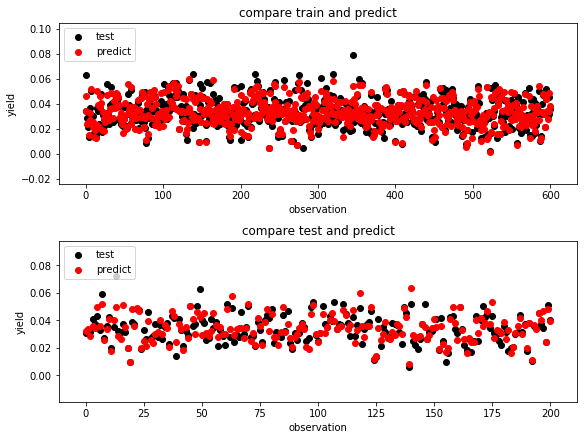

In [40]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 300
model_parameters['verbose'] = 1
model_parameters['layer'] = [20]
model_parameters['dampconst'] = 5
model_parameters['dampfac'] = 0.1
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

In [19]:
#build model that have 2 hidden layers (64, 64)
def buildRegressionModel(model_shape, input_shape, optimizer, loss, metrics, drop_out=None, regularizer_l1=None, regularizer_l2=None, kernel_initializer = 'uniform', drop_out_rate = 0.25):

    # Define a Keras sequential model
    model = keras.Sequential()
    # Define the first dense layer
    for (i, size) in enumerate(model_shape):
        if i ==0:
            model.add(keras.layers.Dense(size, activation='relu', input_shape=[input_shape], kernel_regularizer=regularizer_l2,
                        activity_regularizer=regularizer_l1, kernel_initializer=kernel_initializer))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
        else:
            model.add(keras.layers.Dense(size, activation='relu', kernel_regularizer=regularizer_l2, kernel_initializer=kernel_initializer,
                        activity_regularizer=regularizer_l1))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1, kernel_initializer=kernel_initializer))
    
    #compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [20]:
def trainModel(x_data, y_data, input_shape, parameters):    
    #Build Hypterparameter
    sizes = parameters['sizes'] 
    shapes = parameters['shapes']
    drop_out = parameters['drop_out'] 
    regularizer_l1 = parameters['regularizer_l1']
    regularizer_l2 = parameters['regularizer_l2']
    kernel_initializer = parameters['kernel_initializer']
    drop_out_rate = parameters['drop_out_rate']
    #Compile Hyperparameter
    optimizer = parameters['optimizer']
    #optimizer = keras.optimizers.RMSprop(0.001)
    loss = parameters['loss']
    #loss = 'mae'
    metrics = parameters['metrics']

    #Callback Hyperparameter
    early_stopping = parameters['early_stopping']
    if early_stopping:
        callbacks = [early_stopping]
    else:
        callbacks = None
    verbose = parameters['verbose']
    
    #Train Hyperparameter
    epochs = parameters['epochs']
    validation_split = parameters['validation_split'] 
    
    #Test Train Split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    
    histories ={}
    models = {}
    #build and train model
    for (i, size) in enumerate(sizes):
        models[size] = buildRegressionModel(shapes[i], input_shape, optimizer, loss, metrics, drop_out = drop_out, kernel_initializer = kernel_initializer, 
                                     regularizer_l1=regularizer_l1, regularizer_l2 =regularizer_l2)
        histories[size] = models[size].fit(x_train, y_train, epochs=epochs, validation_data=(x_valid, y_valid), 
                                  callbacks = callbacks, verbose = verbose)
        
        
    #plot results
    colors = ['red', 'blue', 'green', 'yellow']
    plt.figure()
    for i, size in enumerate(sizes):
        data_history = histories[size].history
        loss = data_history['loss']
        val_loss = data_history['val_loss']
        plt.plot(val_loss, color=colors[i], linestyle = '--', label = size + '_val_loss')
        plt.plot(loss, color=colors[i], linestyle = ':', label = size +'_loss')
    
    plt.legend(loc = 'upper left' )
    plt.xlabel = 'epochs'
    plt.ylabel = 'loss'
    
    
    #Show R2 scores
    for i, size in enumerate(sizes):
        #train score
        pred_train = models[size].predict(x_train)
        train_compare = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': pred_train.flatten()})
        train_r2_score = r2_score(train_compare.y_train, train_compare.y_train_pred)
        print(size + ' train r2 score = ', train_r2_score, '/ 1.0')
        
        #test score
        pred_test = models[size].predict(x_test)
        test_compare = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': pred_test.flatten()})
        test_r2_score = r2_score(test_compare.y_test, test_compare.y_test_pred)
        print(size+' test r2 score = ', test_r2_score, '/ 1.0')
        
    return (models, histories)

(802, 6)
(802, 6)
(802, 12)
(802, 15)
(802, 17)
(802, 17)
(802,)
default train r2 score =  0.8429373235305229 / 1.0
default test r2 score =  0.5066325044408042 / 1.0
medium train r2 score =  0.8488927615725157 / 1.0
medium test r2 score =  0.5470278843208352 / 1.0
small train r2 score =  0.8239666874423205 / 1.0
small test r2 score =  0.6321822660285372 / 1.0
tiny train r2 score =  0.7716438351364616 / 1.0
tiny test r2 score =  0.6824530622602295 / 1.0


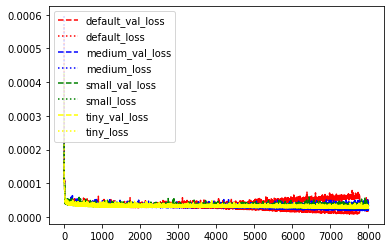

In [41]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default', 'medium']
parameters['shapes'] = [[64,64,64,64], [64,64, 64], [64, 64], [64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = False
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.001

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
# parameters['optimizer'] = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.01
parameters['patience'] = 1000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 8000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = ''
data_parameters['grnn'] = True
data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['remove_bad_yield'] = False
data_parameters['file_parameters'] = ['ch', 'cv']
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']
data_parameters['one_hot_encoded_parameters'] = ['irrigation']

#data Type
data_func = cottonYieldData

models, histories = process(parameters, data_parameters, data_func)